# Initial EDA

In [1]:
# Importing packages
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

In [26]:
# Loading data
df = pd.read_csv('initial_data2.csv')

## Creating new columns
### Some new columns based on features of `Date` column

In [27]:
# Converting Date column to Datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Day of the week column
df['day_of_week'] = df['Date'].dt.day_name()

# Quarter column
df['quarter'] = df['Date'].dt.quarter

# Month column
df['month'] = df['Date'].dt.month

# Year column
df['year'] = df['Date'].dt.year

# Day of year column
df['dayofyear'] = df['Date'].dt.dayofyear

# Day of month column
df['dayofmonth'] = df['Date'].dt.day

# Week of year column
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(np.int64)

### Weekend Boolean column

In [28]:
# Define the function to find weekend values
def weekend(dow):
    if dow == 'Saturday' or dow == 'Sunday':
        return True
    else:
        return False
    
# Apply the function to the Age column using the apply() function
df['weekend'] = df['day_of_week'].apply(weekend)

### Season column

In [29]:
# Defining function to identify season
def get_season(date):
    month = date.month
    day = date.day
    if month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    elif month in [9, 10, 11]:
        season = 'fall'
    else:
        season = 'winter'
    

    if month == 3 and day < 20:
        season = 'winter'
    elif month == 6 and day < 21:
        season = 'spring'
    elif month == 9 and day < 22:
        season = 'summer'
    elif month == 12 and day < 21:
        season = 'fall'
    
    return season

# Applying function and creating season column
df['season'] = df['Date'].apply(get_season)

### Holiday Columns

In [50]:
# Create a list of US holidays for the given year range in the dataframe
us_holidays = holidays.US(years=[df['Date'].dt.year.min(), df['Date'].dt.year.max()]).keys()

# Create Holiday column
df['holidays'] = df['Date'].isin(us_holidays) | (df['Date'] + pd.Timedelta(days=1)).isin(us_holidays)
df['holidays'] = df['holidays'].replace({True: 'Holiday', False: 'Normal day'})

# Determine the holiday season
days_range = pd.date_range(start=df['Date'].min() - pd.Timedelta(days=3),
                           end=df['Date'].max() + pd.Timedelta(days=3))

# Create a DataFrame with a 'holiday_flag' for every date in the days_range
holiday_flags = pd.DataFrame({'Date': days_range})
holiday_flags['holiday_flag'] = holiday_flags['Date'].isin(us_holidays)

# Assign a "holiday season" for every date that's within 3 days of a holiday
df['holiday_season'] = df['Date'].isin(holiday_flags.loc[holiday_flags['holiday_flag'], 'Date'].dt.date + pd.Timedelta(days=3)) | \
                       df['Date'].isin(holiday_flags.loc[holiday_flags['holiday_flag'], 'Date'].dt.date - pd.Timedelta(days=3))

# Delete the 'holiday_flag' column
del holiday_flags['holiday_flag']


### Vaccine Announcement Column 

In [54]:
# Define a list of unique announcement dates
announcement_dates = [
    "04/28/2023", "04/27/2023", "04/18/2023", "03/14/2023", "03/10/2023",
    "12/16/2022", "12/08/2022", "10/21/2022", "10/12/2022", "09/13/2022",
    "08/31/2022", "08/26/2022", "08/19/2022", "07/13/2022", "07/08/2022",
    "06/30/2022", "06/17/2022", "05/17/2022", "05/05/2022", "04/29/2022",
    "04/15/2022", "04/01/2022", "03/29/2022", "03/21/2022", "03/11/2022",
    "02/11/2022", "02/01/2022", "01/31/2022", "01/11/2022", "01/07/2022",
    "01/03/2022", "12/17/2021", "12/14/2021", "12/09/2021", "11/30/2021",
    "11/19/2021", "10/29/2021", "10/26/2021", "10/22/2021", "10/20/2021",
    "10/14/2021", "10/01/2021", "09/24/2021", "09/22/2021", "09/20/2021",
    "09/17/2021", "09/10/2021", "09/02/2021", "09/01/2021", "08/24/2021",
    "08/23/2021", "08/18/2021", "08/13/2021", "08/12/2021", "08/06/2021",
    "08/03/2021", "07/30/2021", "07/16/2021", "07/13/2021", "07/08/2021",
    "07/06/2021", "07/02/2021", "06/29/2021", "06/25/2021", "06/15/2021",
    "06/11/2021", "06/10/2021", "05/25/2021", "05/19/2021", "05/11/2021",
    "05/10/2021", "04/27/2021", "04/23/2021", "04/21/2021", "04/16/2021",
    "04/13/2021", "04/12/2021", "04/01/2021", "03/26/2021", "03/24/2021",
    "03/17/2021", "03/05/2021", "03/02/2021", "02/27/2021", "02/26/2021",
    "02/25/2021", "02/23/2021", "02/22/2021", "02/12/2021", "02/05/2021",
    "02/04/2021", "01/29/2021", "01/14/2021", "01/04/2021", "12/28/2020",
    "12/22/2020", "12/21/2020", "12/18/2020", "12/17/2020", "12/14/2020", "12/12/2020"
]

# Convert to datetime and deduplicate
announcement_dates = list(set([pd.to_datetime(date) for date in announcement_dates]))


# Check if the date in the dataset is within a week of any announcement dates
def near_announcement(date):
    for announcement in announcement_dates:
        if announcement <= date <= (announcement + pd.Timedelta(days=7)):
            return True
    return False

# Create the 'vax_announcement' column
df['vax_announcement'] = df['Date'].apply(near_announcement)


### Finding NaN values and removing variables

In [7]:
### Finding data subset corresponding with first vaccine release 

In [8]:
summary = df.describe()
#summary = summary.T
print(summary)

          MMWR_week   Distributed  Distributed_Janssen  Distributed_Moderna  \
count  38488.000000  3.848800e+04         3.848800e+04         3.848800e+04   
mean      23.434447  1.543719e+07         6.895489e+05         5.803219e+06   
std       15.406757  6.751604e+07         2.981533e+06         2.533753e+07   
min        1.000000  0.000000e+00         0.000000e+00         0.000000e+00   
25%       10.000000  9.751162e+05         2.350000e+04         2.433700e+05   
50%       20.000000  3.837018e+06         1.724000e+05         1.501160e+06   
75%       36.000000  1.004543e+07         4.578000e+05         3.962520e+06   
max       53.000000  9.844443e+08         3.249690e+07         3.522477e+08   

       Distributed_Pfizer  Distributed_Novavax  Distributed_Unk_Manuf  \
count        3.848800e+04         2.688000e+03           3.848800e+04   
mean         8.695934e+06         3.107299e+04           2.081914e+03   
std          3.895544e+07         1.253715e+05           8.327526e+04

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38488 entries, 0 to 38487
Columns: 114 entries, Date to vax_announcement
dtypes: bool(3), datetime64[ns](1), float64(65), int64(42), object(3)
memory usage: 32.7+ MB


In [10]:
# find na value counts

In [32]:
missing_counts = df.isna().sum()

# Sort the missing value counts in descending order
missing_counts_sorted = missing_counts.sort_values(ascending=False)

# Display the sorted missing value counts
with pd.option_context("display.max_rows", None):
    print(missing_counts_sorted)

Second_Booster                            38385
Bivalent_Booster_5Plus                    36568
Bivalent_Booster_5Plus_Pop_Pct            36568
Bivalent_Booster_18Plus                   36504
Bivalent_Booster_12Plus                   36504
Bivalent_Booster_12Plus_Pop_Pct           36504
Bivalent_Booster_18Plus_Pop_Pct           36504
Bivalent_Booster_65Plus                   36504
Bivalent_Booster_65Plus_Pop_Pct           36504
Dist_Bivalent_MOD                         36312
Dist_Bivalent_PFR                         36312
Admin_Bivalent_MOD                        36312
Admin_Bivalent_PFR                        36312
Administered_Bivalent                     36248
Series_Complete_Novavax                   35808
Administered_Novavax                      35807
Distributed_Novavax                       35800
Additional_Doses_5Plus_Vax_Pct            35544
Additional_Doses_5Plus                    35544
Second_Booster_Unk_Manuf                  31907
Second_Booster_Janssen                  

In [12]:
# columns with over 1000 missing values

In [33]:
columns_with_over_1000_missing = missing_counts_sorted[missing_counts_sorted > 1000].index

# Return the names of columns with missing value sum over 1000
columns_with_over_1000_missing

Index(['Second_Booster', 'Bivalent_Booster_5Plus',
       'Bivalent_Booster_5Plus_Pop_Pct', 'Bivalent_Booster_18Plus',
       'Bivalent_Booster_12Plus', 'Bivalent_Booster_12Plus_Pop_Pct',
       'Bivalent_Booster_18Plus_Pop_Pct', 'Bivalent_Booster_65Plus',
       'Bivalent_Booster_65Plus_Pop_Pct', 'Dist_Bivalent_MOD',
       'Dist_Bivalent_PFR', 'Admin_Bivalent_MOD', 'Admin_Bivalent_PFR',
       'Administered_Bivalent', 'Series_Complete_Novavax',
       'Administered_Novavax', 'Distributed_Novavax',
       'Additional_Doses_5Plus_Vax_Pct', 'Additional_Doses_5Plus',
       'Second_Booster_Unk_Manuf', 'Second_Booster_Janssen',
       'Second_Booster_65Plus', 'Second_Booster_65Plus_Vax_Pct',
       'Second_Booster_50Plus_Vax_Pct', 'Second_Booster_Pfizer',
       'Second_Booster_50Plus', 'Second_Booster_Moderna',
       'Additional_Doses_12Plus_Vax_Pct', 'Additional_Doses_12Plus',
       'Series_Complete_Unk_Manuf_5Plus', 'Series_Complete_Janssen_5Plus',
       'Series_Complete_Moderna_5Pl

In [34]:
df = df.drop(columns=columns_with_over_1000_missing)

In [35]:
#df.shape

In [36]:
df.columns

Index(['Date', 'MMWR_week', 'Location', 'Distributed', 'Distributed_Janssen',
       'Distributed_Moderna', 'Distributed_Pfizer', 'Distributed_Unk_Manuf',
       'Dist_Per_100K', 'Distributed_Per_100k_5Plus',
       'Distributed_Per_100k_12Plus', 'Distributed_Per_100k_18Plus',
       'Distributed_Per_100k_65Plus', 'Administered', 'Administered_5Plus',
       'Administered_12Plus', 'Administered_18Plus', 'Administered_65Plus',
       'Administered_Janssen', 'Administered_Moderna', 'Administered_Pfizer',
       'Administered_Unk_Manuf', 'Admin_Per_100K', 'Admin_Per_100k_5Plus',
       'Admin_Per_100k_12Plus', 'Admin_Per_100k_18Plus',
       'Admin_Per_100k_65Plus', 'Recip_Administered',
       'Administered_Dose1_Recip', 'Administered_Dose1_Pop_Pct',
       'Administered_Dose1_Recip_5Plus',
       'Administered_Dose1_Recip_5PlusPop_Pct',
       'Administered_Dose1_Recip_12Plus',
       'Administered_Dose1_Recip_12PlusPop_Pct',
       'Administered_Dose1_Recip_18Plus',
       'Administere

In [17]:
df.head()

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,...,Additional_Doses_65Plus_Vax_Pct,Additional_Doses_Moderna,Additional_Doses_Pfizer,Additional_Doses_Janssen,Additional_Doses_Unk_Manuf,day_of_week,weekend,season,holiday_season,vax_announcement
0,2023-05-10,19,NE,5481710,152400,1647380,2905630,0,283379,303944.0,...,80.7,265916.0,443827.0,7164.0,1215.0,Wednesday,False,spring,False,False
1,2023-05-10,19,LA,10282120,330500,3807980,5164550,0,221178,236516.0,...,69.6,486814.0,608975.0,14004.0,364.0,Wednesday,False,spring,False,False
2,2023-05-10,19,GA,28727475,869100,9763000,14773655,0,270569,288404.0,...,67.8,1155986.0,1518137.0,26699.0,4168.0,Wednesday,False,spring,False,False
3,2023-05-10,19,WY,1281755,49300,490040,585605,0,221466,235691.0,...,71.2,66344.0,77096.0,1930.0,214.0,Wednesday,False,spring,False,False
4,2023-05-10,19,CO,17769135,501900,5402640,9029715,0,308560,327449.0,...,81.0,1019757.0,1410438.0,27303.0,2547.0,Wednesday,False,spring,False,False


In [37]:
columns_to_drop = [
       'Administered_Dose1_Recip',   
       'Administered_Dose1_Recip_5Plus',
       'Administered_Dose1_Recip_12Plus',  
       'Administered_Dose1_Recip_18Plus',
       'Administered_Dose1_Recip_65Plus', 
        'Series_Complete_Yes',
        'Series_Complete_5Plus',
        'Series_Complete_12Plus',
        'Series_Complete_18Plus',
       'Series_Complete_65Plus',
       'Additional_Doses_18Plus', 
       'Additional_Doses_50Plus', 
       'Additional_Doses_65Plus']

In [38]:
# Dropping the columns from the df
df = df.drop(columns = columns_to_drop)

In [39]:
df.columns

Index(['Date', 'MMWR_week', 'Location', 'Distributed', 'Distributed_Janssen',
       'Distributed_Moderna', 'Distributed_Pfizer', 'Distributed_Unk_Manuf',
       'Dist_Per_100K', 'Distributed_Per_100k_5Plus',
       'Distributed_Per_100k_12Plus', 'Distributed_Per_100k_18Plus',
       'Distributed_Per_100k_65Plus', 'Administered', 'Administered_5Plus',
       'Administered_12Plus', 'Administered_18Plus', 'Administered_65Plus',
       'Administered_Janssen', 'Administered_Moderna', 'Administered_Pfizer',
       'Administered_Unk_Manuf', 'Admin_Per_100K', 'Admin_Per_100k_5Plus',
       'Admin_Per_100k_12Plus', 'Admin_Per_100k_18Plus',
       'Admin_Per_100k_65Plus', 'Recip_Administered',
       'Administered_Dose1_Pop_Pct', 'Administered_Dose1_Recip_5PlusPop_Pct',
       'Administered_Dose1_Recip_12PlusPop_Pct',
       'Administered_Dose1_Recip_18PlusPop_Pct',
       'Administered_Dose1_Recip_65PlusPop_Pct', 'Series_Complete_Pop_Pct',
       'Series_Complete_5PlusPop_Pct', 'Series_Complet

In [40]:
df['Additional_Doses_Vax_Pct' ]

0        55.8
1        43.3
2        44.3
3        47.3
4        57.9
         ... 
38483     0.0
38484     0.0
38485     0.0
38486     0.0
38487     0.0
Name: Additional_Doses_Vax_Pct, Length: 38488, dtype: float64

In [41]:
missing_counts = df.isna().sum()

# Sort the missing value counts in descending order
missing_counts_sorted = missing_counts.sort_values(ascending=False)

# Display the sorted missing value counts
with pd.option_context("display.max_rows", None):
    print(missing_counts_sorted)

Admin_Per_100k_5Plus                      448
Series_Complete_5PlusPop_Pct              448
Distributed_Per_100k_5Plus                448
Administered_Dose1_Recip_5PlusPop_Pct     448
Administered_5Plus                        448
Additional_Doses_Unk_Manuf                331
Additional_Doses_Janssen                  327
Additional_Doses_Vax_Pct                  325
Additional_Doses_18Plus_Vax_Pct           325
Additional_Doses_65Plus_Vax_Pct           325
Additional_Doses_Moderna                  325
Additional_Doses_Pfizer                   325
Series_Complete_Unk_Manuf_65Plus            9
Series_Complete_Unk_Manuf                   4
Series_Complete_Unk_Manuf_12Plus            4
Series_Complete_Unk_Manuf_18Plus            4
Administered_Unk_Manuf                      3
Series_Complete_Moderna_65Plus              0
Series_Complete_Pfizer_18Plus               0
Series_Complete_Moderna_18Plus              0
Series_Complete_Janssen_18Plus              0
Series_Complete_Janssen_65Plus    

In [42]:
# Defining response variable for ease
pred_var = 'Additional_Doses_Vax_Pct' 

In [43]:
first_non_zero_date = df.loc[df[pred_var] != 0, 'Date'].min()

print("The first date with a non-zero percentage is:", first_non_zero_date)

The first date with a non-zero percentage is: 2021-09-25 00:00:00


In [44]:
# Define the given date
given_date = pd.to_datetime('2021-09-25')  # Adjust the date as needed

# Subset the DataFrame to include rows with dates greater than the given date
df = df[df['Date'] > given_date]

In [45]:
# final df size after removing unrelated variables and subsetting dates.
df.shape

(19930, 73)

## EDA Response Variable Visuals
### Univariate Analysis

<Axes: xlabel='Additional_Doses_Vax_Pct', ylabel='Count'>

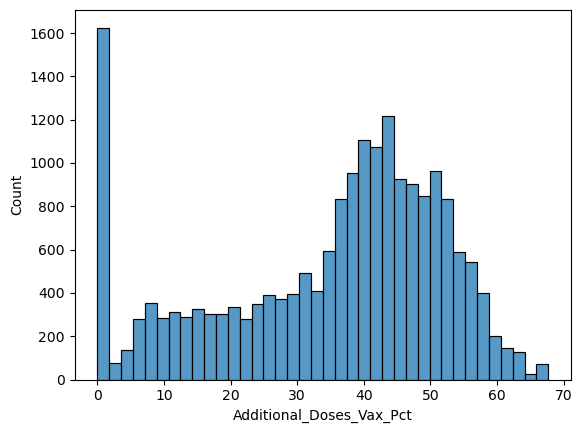

In [46]:
# Distribution of response variable
sns.histplot(df[pred_var], kde=False )

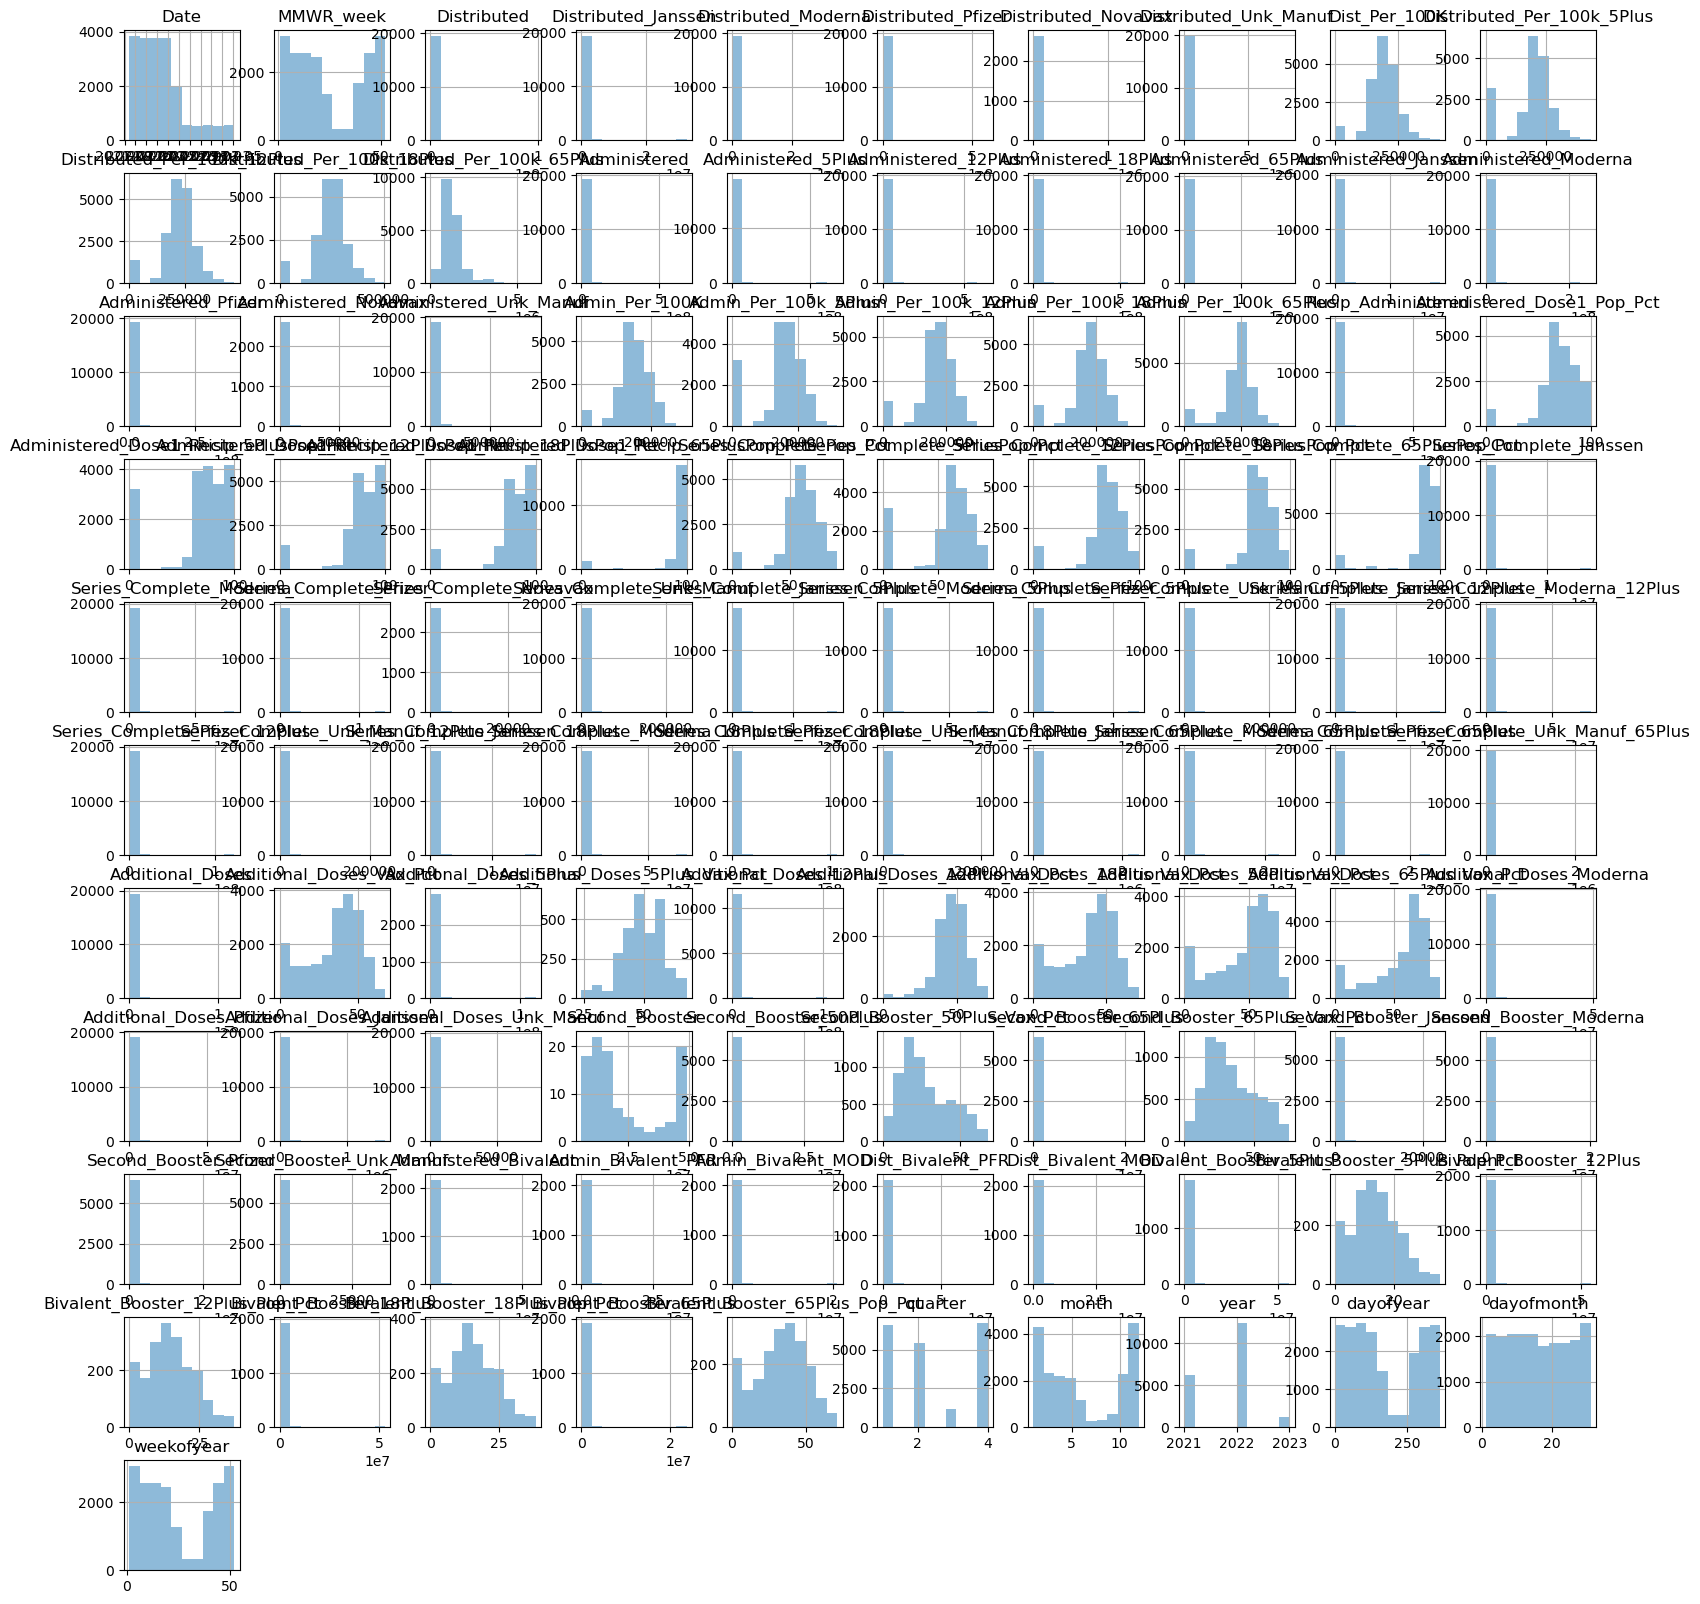

In [21]:
# Distribution of features
df.hist(figsize=(19,20), alpha=0.5);

<Axes: xlabel='season', ylabel='count'>

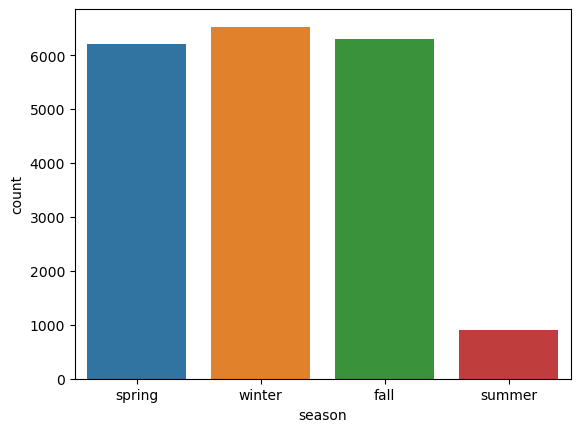

In [47]:
# Distribution of season 
sns.countplot( x = 'season', data = df)

<Axes: xlabel='holidays', ylabel='count'>

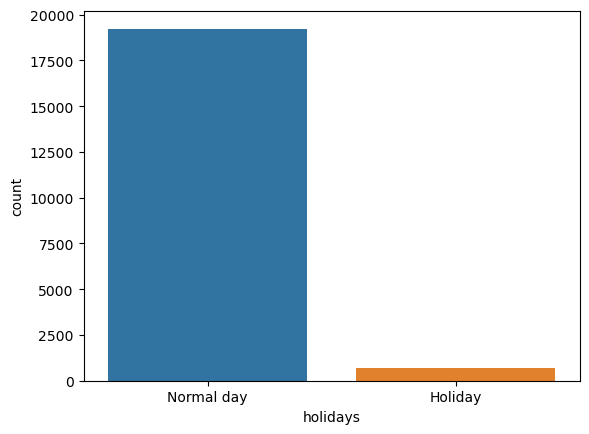

In [52]:
# Distribution of holidays
sns.countplot(x = 'holidays', data = df)

<Axes: xlabel='vax_announcement', ylabel='count'>

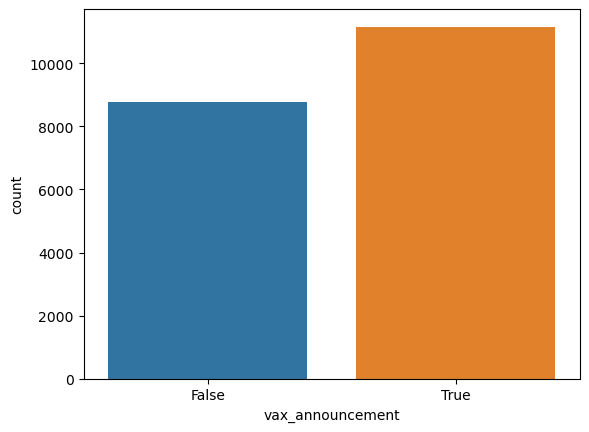

In [55]:
# Distribution of doses near vaccine announcements
sns.countplot(x = 'vax_announcement', data = df)

### Outlier Analysis

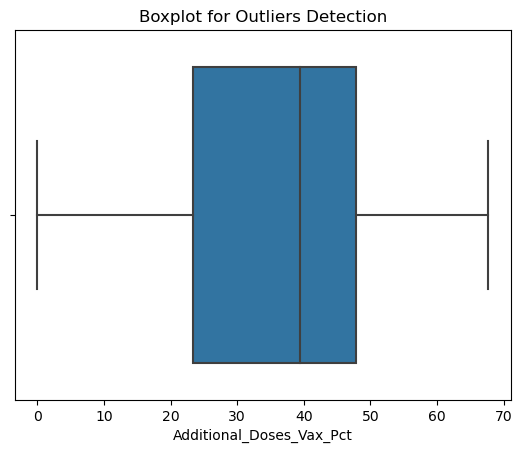

In [56]:
# Box plot to detect outliers
sns.boxplot(x=df[pred_var])
plt.title('Boxplot for Outliers Detection')
plt.show()

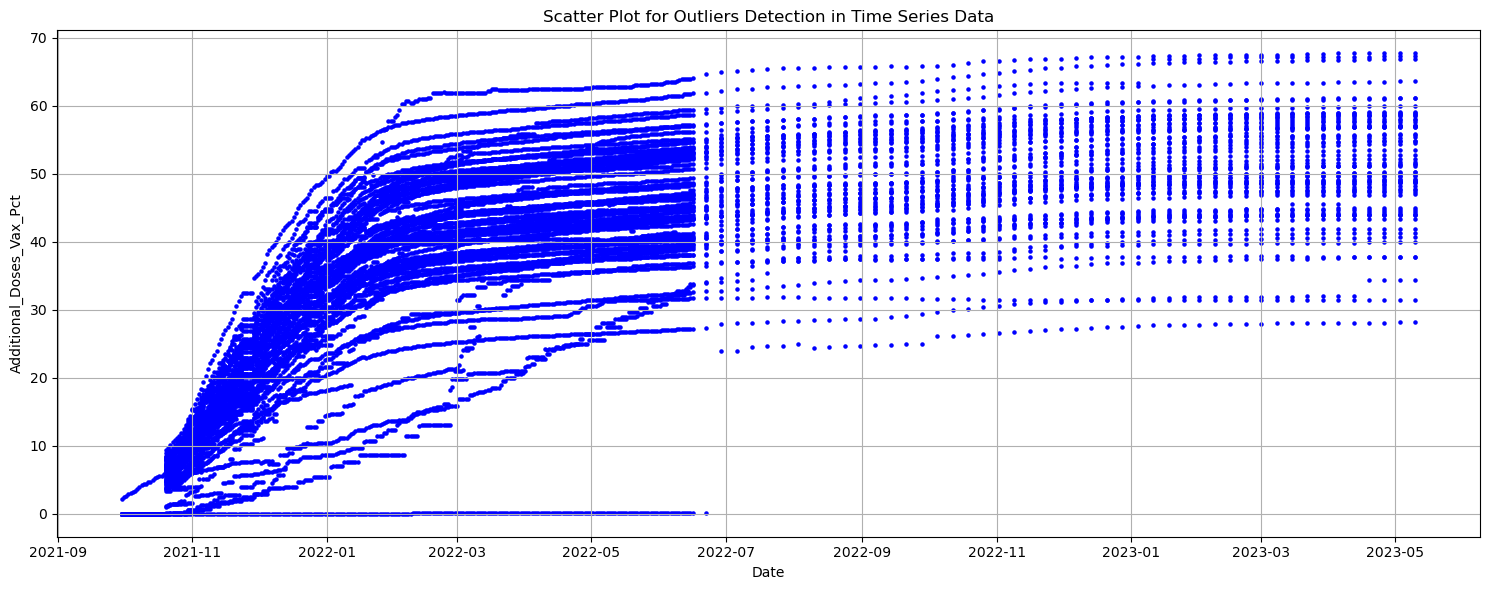

In [57]:
# Scatterplot to determine outliers using the non-unique Dates

plt.figure(figsize=(15, 6))
plt.scatter(df['Date'], df[pred_var], color='blue', s=5)
plt.title('Scatter Plot for Outliers Detection in Time Series Data')
plt.xlabel('Date')
plt.ylabel(pred_var)
plt.grid(True)
plt.tight_layout()
plt.show()

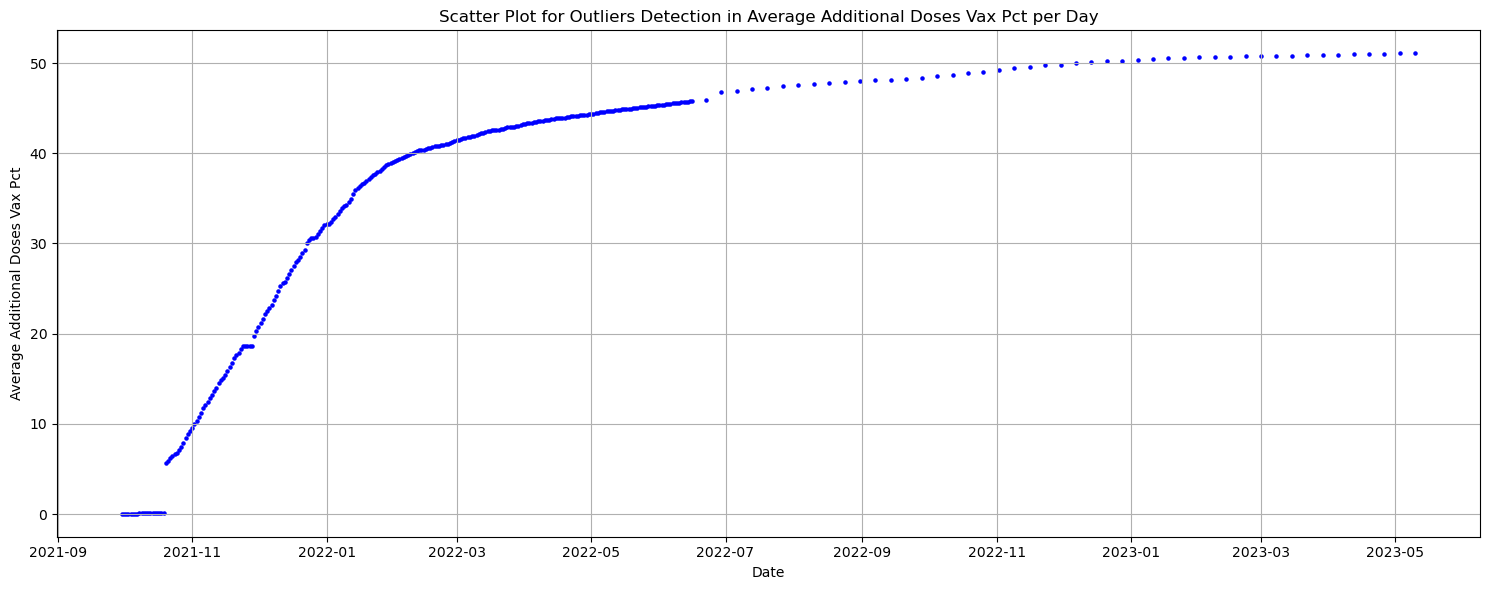

In [58]:
# Scatterplot to determine outliers using mean of all state's response variable on certain Date

# Group by Date and calculate the mean for Additional_Doses_Vax_Pct
avg_vax_pct_per_day = df.groupby('Date')['Additional_Doses_Vax_Pct'].mean().reset_index()

# Scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(avg_vax_pct_per_day['Date'], avg_vax_pct_per_day['Additional_Doses_Vax_Pct'], color='blue', s=5)
plt.title('Scatter Plot for Outliers Detection in Average Additional Doses Vax Pct per Day')
plt.xlabel('Date')
plt.ylabel('Average Additional Doses Vax Pct')
plt.grid(True)
plt.tight_layout()
plt.show()


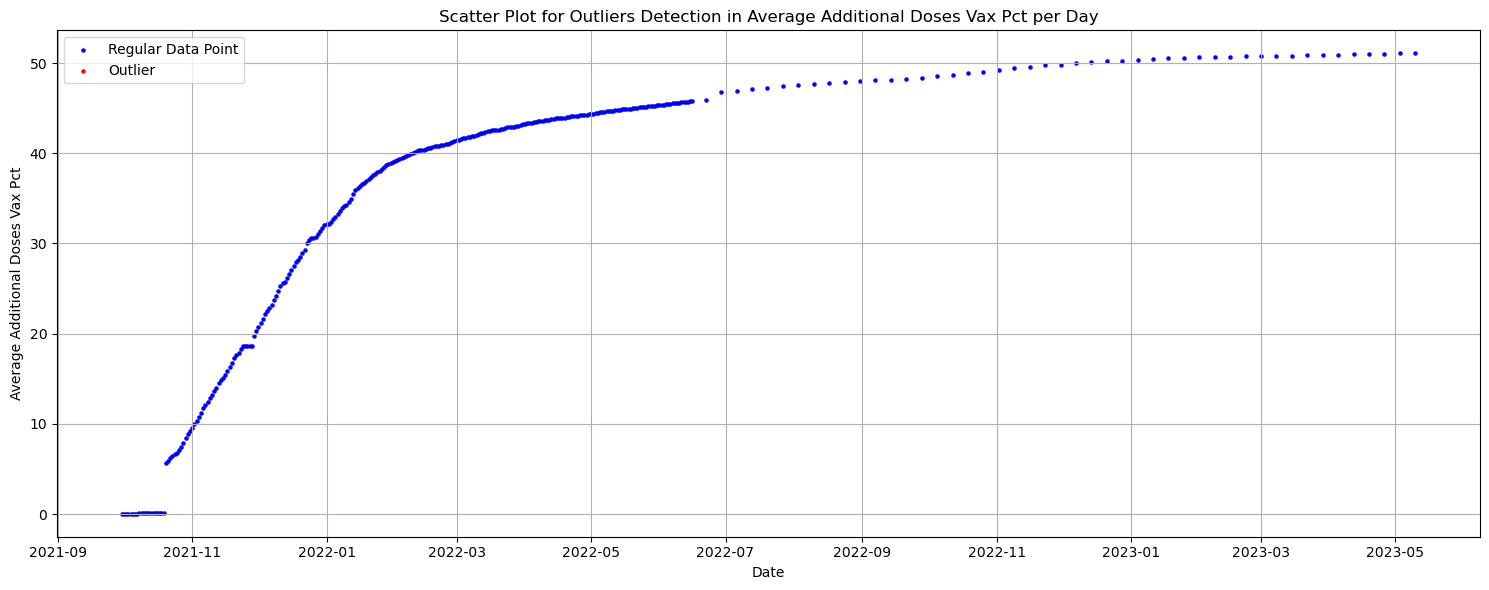

In [59]:
# Scatterplot of averaged response variable with outliers as determined by IQR in red

# Group by Date and calculate the mean for Additional_Doses_Vax_Pct
avg_vax_pct_per_day = df.groupby('Date')['Additional_Doses_Vax_Pct'].mean().reset_index()

# Calculate IQR for the Additional_Doses_Vax_Pct values
Q1 = avg_vax_pct_per_day['Additional_Doses_Vax_Pct'].quantile(0.25)
Q3 = avg_vax_pct_per_day['Additional_Doses_Vax_Pct'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Identify outliers
avg_vax_pct_per_day['is_outlier'] = (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] < lower_bound) | (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] > upper_bound)

# Scatter plot
plt.figure(figsize=(15, 6))

# Plot non-outliers in blue and outliers in red
plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_outlier'] == False]['Date'], avg_vax_pct_per_day[avg_vax_pct_per_day['is_outlier'] == False]['Additional_Doses_Vax_Pct'], color='blue', s=5, label='Regular Data Point')
plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_outlier'] == True]['Date'], avg_vax_pct_per_day[avg_vax_pct_per_day['is_outlier'] == True]['Additional_Doses_Vax_Pct'], color='red', s=5, label='Outlier')

plt.title('Scatter Plot for Outliers Detection in Average Additional Doses Vax Pct per Day')
plt.xlabel('Date')
plt.ylabel('Average Additional Doses Vax Pct')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


There are no clear outliers in the data.

### Correlation

In [27]:
correlations = df.corrwith(df.Additional_Doses_Vax_Pct)
correlations.sort_values(ascending = False)

Additional_Doses_Vax_Pct           1.000000
Additional_Doses_18Plus_Vax_Pct    0.997538
Additional_Doses_50Plus_Vax_Pct    0.987938
Additional_Doses_65Plus_Vax_Pct    0.968749
Admin_Per_100k_5Plus               0.773995
                                     ...   
Distributed_Unk_Manuf             -0.043341
holiday_season                    -0.063956
weekend                           -0.090263
vax_announcement                  -0.197474
MMWR_week                         -0.506858
Length: 63, dtype: float64

In [28]:
high_corr = correlations[abs(correlations) > 0.5]
high_corr

MMWR_week                               -0.506858
Dist_Per_100K                            0.652624
Distributed_Per_100k_5Plus               0.772793
Distributed_Per_100k_12Plus              0.620770
Distributed_Per_100k_18Plus              0.625260
Admin_Per_100K                           0.639276
Admin_Per_100k_5Plus                     0.773995
Admin_Per_100k_12Plus                    0.586445
Admin_Per_100k_18Plus                    0.597145
Admin_Per_100k_65Plus                    0.621125
Administered_Dose1_Recip_5PlusPop_Pct    0.678826
Series_Complete_5PlusPop_Pct             0.710834
Additional_Doses_Vax_Pct                 1.000000
Additional_Doses_18Plus_Vax_Pct          0.997538
Additional_Doses_50Plus_Vax_Pct          0.987938
Additional_Doses_65Plus_Vax_Pct          0.968749
dtype: float64

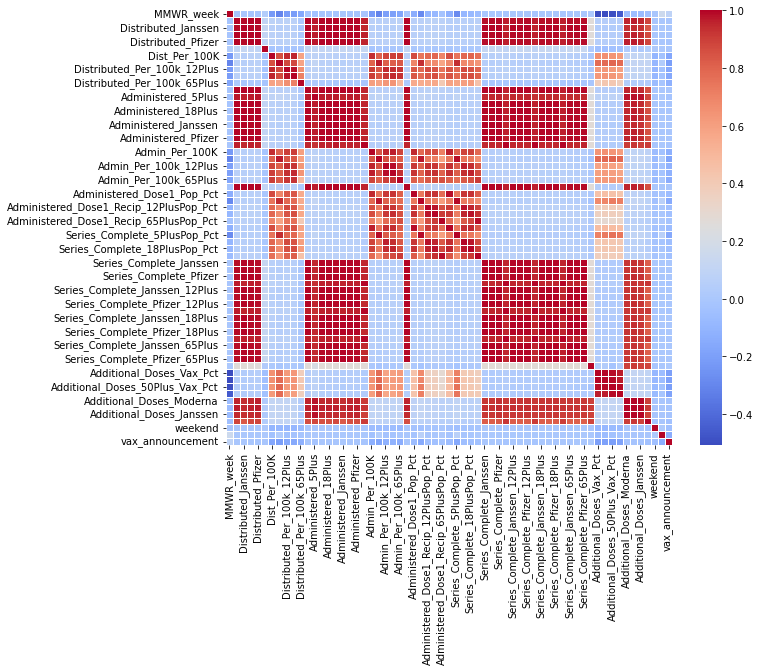

In [29]:
# heat map

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)

# Show the heatmap
plt.show()

### Dealing With NA Values

In [30]:
na = df.isna().sum()
na[na>0]
# biggest missing values in regard to 5 plus population
# could be because vaccines were rolled out to the population but did not include people from ages 5-12 
# going to change the start date to when people of all ages could get vaccine

Distributed_Per_100k_5Plus               448
Administered_5Plus                       448
Administered_Unk_Manuf                     3
Admin_Per_100k_5Plus                     448
Administered_Dose1_Recip_5PlusPop_Pct    448
Series_Complete_5PlusPop_Pct             448
Series_Complete_Unk_Manuf                  4
Series_Complete_Unk_Manuf_12Plus           4
Series_Complete_Unk_Manuf_18Plus           4
Series_Complete_Unk_Manuf_65Plus           9
Additional_Doses_Vax_Pct                 260
Additional_Doses_18Plus_Vax_Pct          260
Additional_Doses_65Plus_Vax_Pct          260
Additional_Doses_Moderna                 260
Additional_Doses_Pfizer                  260
Additional_Doses_Janssen                 262
Additional_Doses_Unk_Manuf               266
dtype: int64

In [31]:
# Define the given date
given_date = pd.to_datetime('2021-11-02')  # Adjust the date as needed

# Subset the DataFrame to include rows with dates greater than the given date
df = df[df['Date'] > given_date]

In [32]:
na = df.isna().sum()
na[na>0]

Administered_Unk_Manuf              3
Series_Complete_Unk_Manuf           4
Series_Complete_Unk_Manuf_12Plus    4
Series_Complete_Unk_Manuf_18Plus    4
Series_Complete_Unk_Manuf_65Plus    9
Additional_Doses_Janssen            2
Additional_Doses_Unk_Manuf          6
dtype: int64

In [33]:
df.shape

(17472, 67)

In [34]:
df2 = df.set_index('Date')

# Count missing values for each date
missing_values_count = df2.isnull().sum(axis=1)

# Sort dates by missing values count in descending order
sorted_dates = missing_values_count.sort_values(ascending=False)

sorted_dates[sorted_dates>0]

Date
2022-12-14    6
2022-12-14    6
2022-12-14    5
2022-12-14    4
2022-12-14    3
2022-12-14    3
2022-12-14    2
2022-12-14    1
2022-12-14    1
2022-12-14    1
dtype: int64

In [35]:
# all missing values from 12-14-2022, identify the states with the missing values

specific_day = '2022-12-14'  # Replace this with your desired date

# Filter the DataFrame for the specific day
specific_day_data = df.loc[df['Date'] == specific_day]

# Get the state names (column names) with missing values on the specific day
rows_with_missing_values = specific_day_data[specific_day_data.isnull().any(axis=1)]


location_values = rows_with_missing_values['Location'].tolist()
location_values

['VI', 'PW', 'BP2', 'AS', 'MP', 'FM', 'VA2', 'MH', 'IH2', 'ND']

In [36]:
df.Location.unique()

array(['NE', 'LA', 'GA', 'WY', 'CO', 'PA', 'DE', 'OR', 'WI', 'ND', 'TX',
       'MN', 'UT', 'SC', 'DC', 'NC', 'WA', 'SD', 'PR', 'RI', 'IA', 'FM',
       'PW', 'NV', 'KY', 'VI', 'WV', 'VA2', 'ME', 'ID', 'BP2', 'MP', 'US',
       'IH2', 'MS', 'IL', 'KS', 'MH', 'FL', 'MO', 'GU', 'VT', 'CT', 'OH',
       'NJ', 'DD2', 'TN', 'CA', 'MT', 'IN', 'NY', 'AL', 'VA', 'MD', 'AR',
       'HI', 'OK', 'NH', 'AZ', 'MI', 'AS', 'AK', 'MA', 'NM', 'RP'],
      dtype=object)

In [37]:
# Filter the DataFrame for dates in D2022
december_2022_data = df[(df['Date'].dt.year == 2022) & (df['Date'].dt.month == 7)]

# Print the filtered DataFrame
print(december_2022_data.Date.unique())

# in july 2022, only gathered data once a week -> will need to work on that next

['2022-07-27T00:00:00.000000000' '2022-07-20T00:00:00.000000000'
 '2022-07-13T00:00:00.000000000' '2022-07-06T00:00:00.000000000']


In [38]:
# Filter the DataFrame for dates in December 2022
december_2022_data = df[(df['Date'].dt.year == 2022) & (df['Date'].dt.month == 12)]

# Print the filtered DataFrame
print(december_2022_data.Date.unique())

['2022-12-28T00:00:00.000000000' '2022-12-21T00:00:00.000000000'
 '2022-12-14T00:00:00.000000000' '2022-12-07T00:00:00.000000000']


In [39]:
for location in location_values:
    # Subset data for the current location
    location_data = df[df['Location'] == location]
    
    # Subset data for the specific dates
    dates_to_impute = location_data[location_data['Date'].isin(['2022-12-07', '2022-12-14'])]
    
    # Perform forward fill (LOCF) imputation for the specific location and dates
    imputed_data = dates_to_impute.fillna(method='ffill', limit=1)
    
    # Update the original DataFrame with the imputed data for the current location
    df.update(imputed_data)


In [40]:
df.isna().sum()

Date                   0
MMWR_week              0
Location               0
Distributed            0
Distributed_Janssen    0
                      ..
day_of_week            0
weekend                0
season                 0
holiday_season         0
vax_announcement       0
Length: 67, dtype: int64

### LAG AND AUTOCORELLATION
Lag is not necessary as there is no clear trends in predicted variable over time.

In [41]:
time_series_data = df.groupby('Date')[pred_var].mean().reset_index()

In [42]:
time_series_data.head()

,Date,Additional_Doses_Vax_Pct
0,2021-11-03,10.332812
1,2021-11-04,10.790625
2,2021-11-05,11.245313
3,2021-11-06,11.745313
4,2021-11-07,12.135938


In [53]:
time_series_data = time_series_data.set_index('Date')

In [49]:
# STL (Seasonal and Trend decomposition using Loess) shows there is no clear seasonality patterns

import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt


#time_series_data.set_index('Date')

# Perform STL decomposition
stl = STL(time_series_data[pred_var], seasonal=10)  # 'seasonal' represents the length of the seasonal component

result = stl.fit()

# Plot the components: trend, seasonal, and residual
fig = result.plot()

# Show the plot
plt.show()

ValueError: Unable to determine period from endog

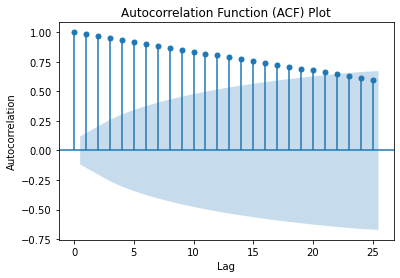

In [55]:
# ACF plot
from statsmodels.graphics.tsaplots import plot_acf

#time_series_data.set_index('Date')

# Create the ACF plot
plot_acf(time_series_data[pred_var])

# Customize the plot (optional)
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Show the plot
plt.show()

 This ACF pattern is commonly observed in time series data with a strong short-term memory or persistence. It may imply that the most recent values have a more pronounced impact on the current value, and the impact of earlier values diminishes gradually. The decay in autocorrelation suggests a relatively fast decrease in correlation with increasing time lags.

Such a pattern is often encountered in financial time series, where recent prices or returns have a significant impact on the current price or return, but the impact of more distant observations becomes less important.

When you encounter this ACF pattern, it may indicate that you should consider autoregressive (AR) models in your time series analysis. AR models capture this kind of autocorrelation and can be useful for making forecasts in situations where recent observations are highly relevant.

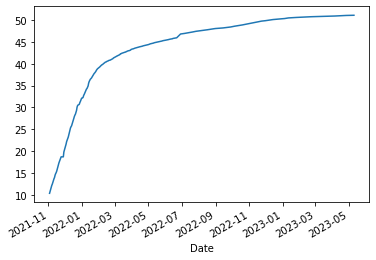

In [56]:
from matplotlib import pyplot
series = time_series_data[pred_var]
series.plot()
pyplot.show()

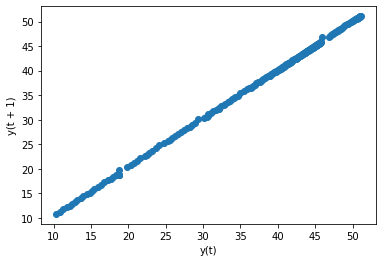

In [57]:
# correlation between current value and the near values
from pandas.plotting import lag_plot
lag_plot(series)
pyplot.show()

In [58]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.999931
t+1  0.999931  1.000000


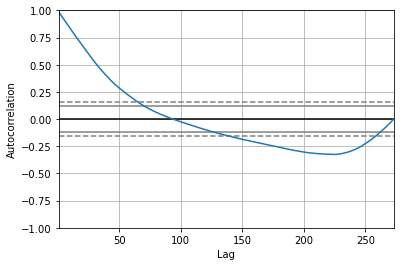

In [59]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()